## **Assignment 3: Generating Text with Recurrent Networks [10pts]**

In this assignment we will dive deep into two applications of text generation and one last image classification application. In the first part we will just work on uncoditioned text generation for generating movie plots. In the second part we will train a model that generates text conditioned on images. In the first two parts of the assignment you will not need to train any model but you have to write the code to use the model after it has been trained.

### **1. Movie Plot Generation [4pts]**
For this part of the assignment we will re-use the dataset from the previous assignment but only use the text part of the dataset.

#### **1.1 Data Loading and Setup**

Same data used in a previous assignment but no images.

In [1]:
# !wget -nc http://www.cs.virginia.edu/~vicente/vislang/mmimdb-noimages.tar.gz
!wget -nc http://www.cs.rice.edu/~vo9/vislang/mmimdb-noimages.tar.gz
!tar xf mmimdb-noimages.tar.gz

--2022-03-12 02:26:03--  http://www.cs.rice.edu/~vo9/vislang/mmimdb-noimages.tar.gz
Resolving www.cs.rice.edu (www.cs.rice.edu)... 128.42.207.26
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:80... connected.
HTTP request sent, awaiting response... 302 Found : Moved Temporarily
Location: https://www.cs.rice.edu/~vo9/vislang/mmimdb-noimages.tar.gz [following]
--2022-03-12 02:26:03--  https://www.cs.rice.edu/~vo9/vislang/mmimdb-noimages.tar.gz
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145318119 (139M) [application/x-gzip]
Saving to: ‘mmimdb-noimages.tar.gz’

mmimdb-noimages.tar 100%[===================>] 138.59M  5.48MB/s    in 26s     

2022-03-12 02:26:29 (5.40 MB/s) - ‘mmimdb-noimages.tar.gz’ saved [145318119/145318119]



#### **1.2 Data Loader Definition**
Unlike the previous assignment here we're writing our own much simpler tokenizer so everything is transparent in its implementation.

In [2]:
import torch, os, json
import numpy as np
from collections import Counter

class MovieDataset(torch.utils.data.Dataset):
    def __init__(self, folder = 'dataset', split = 'dev', vocabulary = None):
        self.json_dir = os.path.join(folder, split, 'metadata')

        # Load JSON files.
        print('Loading %s ...' % self.json_dir, end = '')
        fdir = os.listdir(self.json_dir)
        self.metadata = [(fname[:-5], json.load(open(os.path.join(self.json_dir, fname)))) 
                     for fname in sorted(fdir) if not fname.startswith('.')]
        print(' finished')

        # Compute vocabulary.
        if split == 'train':
            texts = " ".join([m[1]['plot'][0] for m in self.metadata])
            word_counts = Counter(texts.lower().split(" "))
            word_counts = sorted(word_counts, key = word_counts.get, reverse = True)
            self.word2id = {w:i for (i, w) in enumerate(word_counts[:20000])}
            self.word2id['<UNK>'] = 20000
            self.word2id['<START>'] = 20000 + 1
            self.word2id['<END>'] = 20000 + 2
            self.word2id['<PAD>'] = 20000 + 3
            self.id2word = {i:w for (w, i) in self.word2id.items()}
        else:
            self.word2id = vocabulary
            self.id2word = {i:w for (w, i) in self.word2id.items()}

        # Pre-tokenizing all sentences.
        print('Tokenizing...', end = '')
        self.tokenized_plots = list()
        for i in range(0, len(self.metadata)):
            text = self.metadata[i][1]['plot'][0]
            encoded_text = self.tokenize(text)
            self.tokenized_plots.append(encoded_text)
        print(' finished')
            
    def __getitem__(self, index: int):
        _, movie_data = self.metadata[index]
        text = self.tokenized_plots[index]
        return text

    def get_metadata(self, index: int):
        _, movie_data = self.metadata[index]
        return movie_data

    def tokenize(self, text):
        text = text.lower().split(" ")
        encoded_text = [self.word2id.get(w, self.word2id['<UNK>']) for w in text]
        encoded_text = encoded_text[:254]
        encoded_text_array = np.ones(256) * self.word2id['<PAD>']
        encoded_text_array[0] = self.word2id['<START>']
        encoded_text_array[1:len(encoded_text) + 1] = encoded_text
        encoded_text_array[len(encoded_text) + 1] = self.word2id['<END>']
        return torch.tensor(encoded_text_array, dtype = torch.long)

    def untokenize(self, token_ids):
        return [self.id2word[id] for id in token_ids.detach().numpy()]

    def __len__(self):
        return len(self.metadata)

train_data = MovieDataset(split = 'train')
val_data = MovieDataset(split = 'dev', vocabulary = train_data.word2id)

text = val_data[1230]
print(val_data.untokenize(text))
print('Data size: %d samples' % len(val_data))

Loading dataset/train/metadata ... finished
Tokenizing... finished
Loading dataset/dev/metadata ... finished
Tokenizing... finished
['<START>', 'a', 'gangster', 'boss', '<UNK>', 'has', 'a', 'list', 'of', 'about', '100', 'people', 'who', 'have', '<UNK>', 'up', 'at', 'one', 'point', 'or', 'another.', 'rather', 'than', '<UNK>', 'killing', 'them,', 'he', 'decides', 'to', 'have', 'a', 'little', 'fun', 'by', 'putting', 'all', 'of', 'them', 'together', 'in', 'a', 'high', 'security', 'prison,', '<UNK>', 'and', 'dumping', '<UNK>', 'of', 'guns,', '<UNK>', 'and', 'baseball', 'bats', 'on', 'them', 'and', 'letting', 'them', 'kill', 'each', 'other.', 'the', 'final', 'three', 'who', 'survive', 'are', 'given', 'a', 'prize', 'of', '10', 'million', 'dollars.', 'let', 'chaos', '<UNK>', '<END>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>

#### **1.3 Data Loader Usage**
Here we show how to use the data loader to obtain a sample from the training data and show it with reasonable formatting.

In [3]:
import numpy as np
import math

sample_movieID = 2241
text = val_data[sample_movieID]

# Show a plot from the validation set. 
def pretty_print(data: torch.utils.data.Dataset, 
                 token_list: str, 
                 cols: int = 80,
                 hide_padding: bool = True,
                 untokenize_needed = True):
    if untokenize_needed:
        token_list = val_data.untokenize(token_list)
    if hide_padding:
        token_list = [t for t in token_list if t != '<PAD>']
    plot_string = " ".join(token_list)
    for i in range(0, math.ceil(len(plot_string) / cols)):
        print(plot_string[i * cols : (i + 1) * cols])

# Show a movie plot
pretty_print(val_data, text, hide_padding = False)

<START> ruthless executive christine brings on isabelle as her assistant, and sh
e takes delight in <UNK> with the young woman's innocence. but when the <UNK> id
eas become <UNK> enough for christine to pass on as her own, she <UNK> <UNK> amb
ition and cunning -- and the ground is set for all out war. <END> <PAD> <PAD> <P
AD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD
> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P
AD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD
> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P
AD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD
> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
<PAD> <PAD> <PAD> <PAD> <PAD

#### **1.4 Training a Recurrent Neural Network**

First let's define a module in pytorch that uses a recurrent neural network.



In [4]:
import torch.nn as nn
from torch.nn import functional as F

class TextGenerator(nn.Module):
  
    def __init__(self, word_embedding_size: int, 
                 state_size: int, 
                 vocab_size: int):
        super(TextGenerator, self).__init__()
        self.state_size = state_size
        self.num_layers = 3
        
        self.embedding = nn.Embedding(vocab_size, word_embedding_size)
        self.rnn = nn.GRU(word_embedding_size, state_size, batch_first = True, 
                          num_layers = self.num_layers, dropout=0.2)
        self.predictionLayer = nn.Linear(state_size, vocab_size)

    def dummy_input_state(self, batch_size):
        dummy_state = torch.zeros(self.num_layers, batch_size, self.state_size)
        return dummy_state
        
    def forward(self, input_state, input_token_ids):
        # Embed the input token ids into a set of word vectors.
        word_embeddings = self.embedding(input_token_ids)
        
        # Pass the embedding through the RNN.
        output_states, final_output_state = self.rnn(word_embeddings, input_state)
        
        # Output prediction.
        word_scores = self.predictionLayer(output_states)
        
        return word_scores, final_output_state

# Test the model.
generator = TextGenerator(word_embedding_size = 300, 
                          state_size = 256, 
                          vocab_size = len(val_data.word2id))

generator.eval()
input_state = generator.dummy_input_state(batch_size = 1)
predicted_word_scores, _ = generator(input_state, text.unsqueeze(0)) # why unsqueeze?
predicted_word_scores = F.softmax(predicted_word_scores[0].detach(), dim = 1)

# The model predicts garbage text (of course).
max_scores, predicted_word_ids = predicted_word_scores.max(dim = 1)
print(pretty_print(val_data, predicted_word_ids))

movie, strikes, strikes, lou lou lou husband husband husband stepped stepped get
s gets gets poet poet does, does, writer's wannabe survival. survival. survival.
 basically magicians photograph photograph photograph noah's act, began began ch
ap. stopping stopping general. even glass. image, humorous, humorous, gets image
, image, roof roof roof roof roof prostitutes iconic prostitutes happily dark, s
trikes, regardless, regardless, regardless, regardless, regardless, regardless, 
regardless, regardless, regardless, regardless, regardless, regardless, regardle
ss, regardless, soft soft soft soft soft soft soft soft soft soft soft soft soft
 soft soft soft soft soft soft soft soft soft soft soft soft soft soft soft soft
 soft soft soft soft soft soft soft soft soft soft soft soft soft soft soft soft
 soft soft soft soft soft soft soft soft soft soft soft soft soft soft soft soft
 soft soft soft soft soft soft soft soft soft soft soft soft soft soft soft soft
 soft soft soft soft soft so

#### **1.5 Training the RNN**
Training the model by feeding it shifted input and output text pairs (Auto-Regressive). Please go back to the slides on Recurrent Neural Networks if needed.

In [5]:
!pip install pytorch-lightning --quiet

import random 
import pytorch_lightning as pl

# The pytorch lighting library requires inheriting from pl.LightingModule.
class TextGeneratorWrapper(pl.LightningModule):
    def __init__(self, textGenerator: TextGenerator, 
                       criterion: nn.Module):
        super().__init__()
        self.textGenerator = textGenerator
        self.learning_rate = 0.001
        self.criterion = criterion 

    # Use the textGenerator forward.
    def forward(self, input_state, input_token_ids):
       return self.textGenerator(input_state, input_token_ids)

    # Define how we treat a batch during training.
    def training_step(self, batch, batch_idx):
        texts = batch

        # Create tensor for the initial input state of the RNN.
        input_state = \
            self.textGenerator.dummy_input_state(batch_size = texts.shape[0])
        input_state = input_state.to(texts.device) # Move to same device as texts e.g. cuda.

        # Compute the predicted texts.
        predicted_texts, _ = self(input_state, texts)
        
        # Define the target texts. These are shifted versions of the input.
        target_texts =  texts[:, 1:].contiguous()

        # Use cross entropy loss.
        # However we need to collapase the batch and sequence length dimensions.
        num_classes = predicted_texts.shape[2]

        loss = self.criterion(
            predicted_texts[:, :-1, :].contiguous().view(-1, num_classes),
            target_texts.view(-1))
        
        self.log('train_loss', loss, on_epoch = True)
        return loss

    # Very similar to training_step.
    def validation_step(self, batch, batch_idx):
        texts = batch

        # Create tensor for the initial input state of the RNN.
        input_state = \
            self.textGenerator.dummy_input_state(batch_size = texts.shape[0])
        input_state = input_state.to(texts.device) # Move to same device as texts e.g. cuda.

        # Compute the predicted texts.
        predicted_texts, _ = self(input_state, texts)
        
        # Define the target texts. These are shifted versions of the input.
        target_texts =  texts[:, 1:].contiguous()

        # Use cross entropy loss.
        # However we need to collapase the batch and sequence length dimensions.
        num_classes = predicted_texts.shape[2]

        loss = self.criterion(
            predicted_texts[:, :-1, :].contiguous().view(-1, num_classes),
            target_texts.view(-1))
        
        self.log('val_loss', loss, on_epoch = True)
        return {'val_loss': loss}
    
    def training_epoch_end(self, outputs):
        loss_mean = torch.stack([x['loss'] for x in outputs]).mean()
        print('Training loss %.2f at epoch %d' %  (loss_mean, self.current_epoch))

    def validation_epoch_end(self, outputs):
        loss_mean = torch.stack([x['val_loss'] for x in outputs]).mean()
        print('Validation loss %.2f at epoch %d' %  (loss_mean, self.current_epoch))

    def configure_optimizers(self):
        return [torch.optim.Adam(self.textGenerator.parameters(), 
                                 lr = self.learning_rate)], []

     |████████████████████████████████| 527 kB 4.9 MB/s 
     |████████████████████████████████| 397 kB 47.7 MB/s 
     |████████████████████████████████| 829 kB 42.6 MB/s 
     |████████████████████████████████| 134 kB 46.9 MB/s 
     |████████████████████████████████| 596 kB 3.7 MB/s 
     |████████████████████████████████| 952 kB 40.6 MB/s 
     |████████████████████████████████| 1.1 MB 38.2 MB/s 
     |████████████████████████████████| 144 kB 48.6 MB/s 
     |████████████████████████████████| 271 kB 52.3 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [6]:
# Batch size is a liming factor on constrained resources.
# only GPUs with a large memory can hold large batches.
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           pin_memory = True,
                                           num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_data, 
                                         batch_size = batch_size, 
                                         shuffle = False)

# Define loss function.
# Cross entropy but ignore predicting the [PAD] token.
cost_function = nn.CrossEntropyLoss(ignore_index = val_data.word2id['<PAD>'])

Now, here the training loop is greatly simplifed using pytorch lighting. You can even try using TPUs! Or paralellize your training to multiple GPUs very easily.

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

# Callback to save a model checkpoint (weights).
checkpoint_callback = ModelCheckpoint(
    filename = 'checkpoints/text_generator_weights_{epoch:03d}-{val_loss:.2f}',
    verbose = True, monitor = 'val_loss', mode = 'min', save_top_k = 1)

# Create the model.
plotGenerator = TextGenerator(word_embedding_size = 300, 
                          state_size = 256, 
                          vocab_size = len(train_data.word2id))
plotGeneratorWrapper = TextGeneratorWrapper(plotGenerator,
                                            cost_function)

# # Simple thanks to Pytorch Lighting.
trainer = pl.Trainer(gradient_clip_val = 5.0, gpus = 1, 
                     min_epochs = 20, max_epochs = 20,
                     callbacks = [checkpoint_callback],#
                     limit_train_batches = 1.0, # Use all the data.
                     enable_model_summary = False) 

# # Train the model.
trainer.fit(plotGeneratorWrapper, 
            train_dataloaders = train_loader,
            val_dataloaders = [val_loader]) 

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /content/lightning_logs


Validation sanity check: 0it [00:00, ?it/s]

Validation loss 9.90 at epoch 0


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 242: val_loss reached 6.60725 (best 6.60725), saving model to "/content/lightning_logs/version_0/checkpoints/checkpoints/text_generator_weights_epoch=000-val_loss=6.61.ckpt" as top 1


Validation loss 6.61 at epoch 0
Training loss 6.87 at epoch 0


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 485: val_loss reached 6.58531 (best 6.58531), saving model to "/content/lightning_logs/version_0/checkpoints/checkpoints/text_generator_weights_epoch=001-val_loss=6.59.ckpt" as top 1


Validation loss 6.59 at epoch 1
Training loss 6.73 at epoch 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 728: val_loss reached 6.45969 (best 6.45969), saving model to "/content/lightning_logs/version_0/checkpoints/checkpoints/text_generator_weights_epoch=002-val_loss=6.46.ckpt" as top 1


Validation loss 6.46 at epoch 2
Training loss 6.64 at epoch 2


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 971: val_loss reached 6.40035 (best 6.40035), saving model to "/content/lightning_logs/version_0/checkpoints/checkpoints/text_generator_weights_epoch=003-val_loss=6.40.ckpt" as top 1


Validation loss 6.40 at epoch 3
Training loss 6.56 at epoch 3


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 1214: val_loss reached 6.23789 (best 6.23789), saving model to "/content/lightning_logs/version_0/checkpoints/checkpoints/text_generator_weights_epoch=004-val_loss=6.24.ckpt" as top 1


Validation loss 6.24 at epoch 4
Training loss 6.45 at epoch 4


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 1457: val_loss reached 6.07585 (best 6.07585), saving model to "/content/lightning_logs/version_0/checkpoints/checkpoints/text_generator_weights_epoch=005-val_loss=6.08.ckpt" as top 1


Validation loss 6.08 at epoch 5
Training loss 6.27 at epoch 5


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 1700: val_loss reached 5.91816 (best 5.91816), saving model to "/content/lightning_logs/version_0/checkpoints/checkpoints/text_generator_weights_epoch=006-val_loss=5.92.ckpt" as top 1


Validation loss 5.92 at epoch 6
Training loss 6.11 at epoch 6


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 1943: val_loss reached 5.73026 (best 5.73026), saving model to "/content/lightning_logs/version_0/checkpoints/checkpoints/text_generator_weights_epoch=007-val_loss=5.73.ckpt" as top 1


Validation loss 5.73 at epoch 7
Training loss 5.92 at epoch 7


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 2186: val_loss reached 5.55851 (best 5.55851), saving model to "/content/lightning_logs/version_0/checkpoints/checkpoints/text_generator_weights_epoch=008-val_loss=5.56.ckpt" as top 1


Validation loss 5.56 at epoch 8
Training loss 5.72 at epoch 8


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 2429: val_loss reached 5.43447 (best 5.43447), saving model to "/content/lightning_logs/version_0/checkpoints/checkpoints/text_generator_weights_epoch=009-val_loss=5.43.ckpt" as top 1


Validation loss 5.43 at epoch 9
Training loss 5.54 at epoch 9


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 2672: val_loss reached 5.35613 (best 5.35613), saving model to "/content/lightning_logs/version_0/checkpoints/checkpoints/text_generator_weights_epoch=010-val_loss=5.36.ckpt" as top 1


Validation loss 5.36 at epoch 10
Training loss 5.39 at epoch 10


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 2915: val_loss reached 5.29822 (best 5.29822), saving model to "/content/lightning_logs/version_0/checkpoints/checkpoints/text_generator_weights_epoch=011-val_loss=5.30.ckpt" as top 1


Validation loss 5.30 at epoch 11
Training loss 5.27 at epoch 11


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 3158: val_loss reached 5.25768 (best 5.25768), saving model to "/content/lightning_logs/version_0/checkpoints/checkpoints/text_generator_weights_epoch=012-val_loss=5.26.ckpt" as top 1


Validation loss 5.26 at epoch 12
Training loss 5.16 at epoch 12


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 3401: val_loss reached 5.23099 (best 5.23099), saving model to "/content/lightning_logs/version_0/checkpoints/checkpoints/text_generator_weights_epoch=013-val_loss=5.23.ckpt" as top 1


Validation loss 5.23 at epoch 13
Training loss 5.07 at epoch 13


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 3644: val_loss reached 5.21673 (best 5.21673), saving model to "/content/lightning_logs/version_0/checkpoints/checkpoints/text_generator_weights_epoch=014-val_loss=5.22.ckpt" as top 1


Validation loss 5.22 at epoch 14
Training loss 4.98 at epoch 14


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 3887: val_loss reached 5.21096 (best 5.21096), saving model to "/content/lightning_logs/version_0/checkpoints/checkpoints/text_generator_weights_epoch=015-val_loss=5.21.ckpt" as top 1


Validation loss 5.21 at epoch 15
Training loss 4.90 at epoch 15


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 4130: val_loss reached 5.20787 (best 5.20787), saving model to "/content/lightning_logs/version_0/checkpoints/checkpoints/text_generator_weights_epoch=016-val_loss=5.21.ckpt" as top 1


Validation loss 5.21 at epoch 16
Training loss 4.82 at epoch 16


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 4373: val_loss was not in top 1


Validation loss 5.21 at epoch 17
Training loss 4.75 at epoch 17


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 4616: val_loss was not in top 1


Validation loss 5.22 at epoch 18
Training loss 4.68 at epoch 18


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 4859: val_loss was not in top 1


Validation loss 5.23 at epoch 19
Training loss 4.62 at epoch 19


#### **1.6 Re-Using a Pretrained Model**
I have a model ready for you to use posted online. Feel free to use this instead of running the training code above.

In [7]:
plotGenerator = TextGenerator(word_embedding_size = 300, 
                          state_size = 256, 
                          vocab_size = len(train_data.word2id))
plotGeneratorWrapper = TextGeneratorWrapper(plotGenerator,
                                            cost_function)

# Remember wget -nc makes sure you don't download the file twice if already downloaded.
# !wget -nc http://www.cs.virginia.edu/~vicente/vislang/text_generator_weights_epoch\=011-val_loss\=1.72.ckpt
#!wget -nc http://www.cs.rice.edu/~vo9/vislang/text_generator_weights_epoch\=011-val_loss\=1.72.ckpt
!wget -nc http://www.cs.rice.edu/~vo9/vislang/text_generator_weights_epoch\=015-val_loss\=5.20.ckpt
#checkpoint = torch.load('text_generator_weights_epoch=011-val_loss=1.72.ckpt')
#checkpoint = torch.load('checkpoints/text_generator_weights_epoch=015-val_loss=5.20.ckpt')
checkpoint = torch.load('text_generator_weights_epoch=015-val_loss=5.20.ckpt')
plotGeneratorWrapper.load_state_dict(checkpoint['state_dict'])

--2022-03-12 02:28:11--  http://www.cs.rice.edu/~vo9/vislang/text_generator_weights_epoch=015-val_loss=5.20.ckpt
Resolving www.cs.rice.edu (www.cs.rice.edu)... 128.42.207.26
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:80... connected.
HTTP request sent, awaiting response... 302 Found : Moved Temporarily
Location: https://www.cs.rice.edu/~vo9/vislang/text_generator_weights_epoch=015-val_loss=5.20.ckpt [following]
--2022-03-12 02:28:11--  https://www.cs.rice.edu/~vo9/vislang/text_generator_weights_epoch=015-val_loss=5.20.ckpt
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 148335548 (141M)
Saving to: ‘text_generator_weights_epoch=015-val_loss=5.20.ckpt’

text_generator_weig 100%[===================>] 141.46M  5.51MB/s    in 26s     

2022-03-12 02:28:37 (5.49 MB/s) - ‘text_generator_weights_epoch=015-val_loss=5.20.ckpt’ saved [148335548/148335548]



<All keys matched successfully>

#### **1.7 Generating a Movie plots [4pts]**

##### **1.7.1 Next Token Prediction**

First let's see what the model has learned to predict next to an input <START> token.

In [8]:
# Always set network in eval mode.
plotGenerator.eval()

# Try modifying the temperature and see what it does to both
# the probability scores and the next token prediction.
# What happens when you set it to 0.5? What if you set it to 1.0?
kTemperature = 0.9

# Create input token.
token = '<START>'
# Keep in mind we have to add a dummy sequence dimension.
input_token = torch.tensor(val_data.word2id[token]).unsqueeze(0)

# Create the input state h_0 for the RNN.
input_state = plotGenerator.dummy_input_state(batch_size = 1)

# Predict the next token softmax scores.
# Keep in mind we have to add a dummy batch dimension.
predicted_tokens, next_state = plotGenerator(input_state, input_token.unsqueeze(0))

# Take the output predictions from the LSTM for the next token.
# Apply the softmax and let's use a kTemperature parameter here.
next_token_scores = predicted_tokens[0, -1, :].detach().div(kTemperature).softmax(dim = 0)
next_token_scores = next_token_scores.detach().clone()

# Let's sort the scores in descending order and show the top scored words.
sorted_token_scores, sorted_token_ids = next_token_scores.sort(dim = 0, descending = True)
for (token, score) in zip(sorted_token_ids[:12], sorted_token_scores[:12]):
    print('P[%s] = %.4f' % (val_data.id2word[token.item()], score.item()))

# Now let's sample a token using the probability scores.
# Please see the numpy documentation for np.random.choice.
next_token_id = np.random.choice(len(next_token_scores), p = next_token_scores.numpy())
print('\nGenerated next token following <START>: \"%s\"' % val_data.id2word[next_token_id])

P[a] = 0.2103
P[<UNK>] = 0.1269
P[in] = 0.1086
P[the] = 0.1066
P[when] = 0.0392
P[an] = 0.0314
P[this] = 0.0254
P[after] = 0.0232
P[two] = 0.0172
P[on] = 0.0128
P[set] = 0.0103
P[at] = 0.0079

Generated next token following <START>: "he"


##### **1.7.2 Full Movie Plot Generation [2pts]**.

Write code here that generates a complete Movie Plot from this trained RNN. I'm showing below an example of a movie plot (using kTemperature = 0.9).


In [162]:
plotGenerator.eval()
results = []
token = '<START>'
results.append(token)
input_state = plotGenerator.dummy_input_state(batch_size = 1)
for i in range(254):
  input_token = torch.tensor(val_data.word2id[token]).unsqueeze(0)

# Create the input state h_0 for the RNN.

# Predict the next token softmax scores.
# Keep in mind we have to add a dummy batch dimension.
  predicted_tokens, next_state = plotGenerator(input_state, input_token.unsqueeze(0))

# Take the output predictions from the LSTM for the next token.
# Apply the softmax and let's use a kTemperature parameter here.
  next_token_scores = predicted_tokens[0, -1, :].detach().div(kTemperature).softmax(dim = 0)
  next_token_scores = next_token_scores.detach().clone()

# Let's sort the scores in descending order and show the top scored words.
  next_token_id = np.random.choice(len(next_token_scores), p = next_token_scores.numpy())
  token = val_data.id2word[next_token_id]
  input_state = next_state
  results.append(token)
  if token == '<END>':
    break

In [163]:
print(' '.join(results))

<START> herman smith has demons from taking over funding in the united states london city of england. on the way of trouble, here, <UNK> is retired and very many years later with his scheduled tour of the nation. in 2007, a new promiscuous visits where they have a holiday exhibit from the delta rider banquet with <UNK> ed <UNK> and former little sixties with their <UNK> emily <UNK> <UNK> and daughter jane ed and the flamboyant forsyte of <UNK> and <UNK> <UNK> ideals with <UNK> and proper magic <UNK> as they <UNK> the film follows resemble interviews and <UNK> the french duo attend the expectations of christianity and achieve them and assault for the way of these years. <END>


##### **1.7.3 Generate a Movie Plot using a Prompt [2pts]**

Now write code to generate a movie plot that start as follows:

"A woman starts a journey..."

Make your code general enough to accept any arbitrary starting phrase.

In [164]:
plotGenerator.eval()

input_state = plotGenerator.dummy_input_state(batch_size = 1)
phrase = "A woman starts a journey"
phrase_ls = phrase.lower().split(" ")
n = len(phrase_ls)
for i in range(n-1):
  token = phrase_ls[i]
  input_token = torch.tensor(val_data.word2id[token]).unsqueeze(0)

# Create the input state h_0 for the RNN.

# Predict the next token softmax scores.
# Keep in mind we have to add a dummy batch dimension.
  predicted_tokens, next_state = plotGenerator(input_state, input_token.unsqueeze(0))

# Take the output predictions from the LSTM for the next token.
# Apply the softmax and let's use a kTemperature parameter here.
  next_token_scores = predicted_tokens[0, -1, :].detach().div(kTemperature).softmax(dim = 0)
  next_token_scores = next_token_scores.detach().clone()

# Let's sort the scores in descending order and show the top scored words.
  
  input_state = next_state
  

In [169]:
plotGenerator.eval()
results.append(token)
results = []
results.append('<START>')
results += phrase_ls

token = phrase_ls[n-1]
for i in range(256):
  input_token = torch.tensor(val_data.word2id[token]).unsqueeze(0)

# Create the input state h_0 for the RNN.

# Predict the next token softmax scores.
# Keep in mind we have to add a dummy batch dimension.
  predicted_tokens, next_state = plotGenerator(input_state, input_token.unsqueeze(0))

# Take the output predictions from the LSTM for the next token.
# Apply the softmax and let's use a kTemperature parameter here.
  next_token_scores = predicted_tokens[0, -1, :].detach().div(kTemperature).softmax(dim = 0)
  next_token_scores = next_token_scores.detach().clone()

# Let's sort the scores in descending order and show the top scored words.
  next_token_id = np.random.choice(len(next_token_scores), p = next_token_scores.numpy())
  token = val_data.id2word[next_token_id]
  input_state = next_state
  results.append(token)
  if token == '<END>':
    break



In [170]:
print(' '.join(results))

<START> a woman starts a journey to paris. some years in their own battle with each other? but it has far him into the abuse of <UNK> past. and jealousy from turmoil within the <UNK> who was facing the most dangerous chain of luc artificial characters, hurtling through the world. <END>


### **2. Image Captioning [4pts]**
The objective of this project is to create an image captioning system consisting of a CNN connected to an RNN to describe images in German. We will rely on the Multi30k dataset containing images with captions in German.

#### **2.1. Download Resources and Setup the Environment**

In this part of the assignment we will work with the Multi30k dataset, this dataset was created by a team at the University of Sheffield, University of Copenhagen and the University of Edinburgh. You can find their repository here https://github.com/toshohirasawa/multi30k.

The dataset has 30,000 images from a previous dataset called Flickr30k which was collected earlier by a team at the University of Illinois. However, Multi30k contains image descriptions in German, French, English and Czech. We will use Task2 from this dataset which contains only German and English. We will focus on German in this assignment.



In [14]:
# Download data for the flickr30k dataset and multi30k dataset.
!wget -nc http://www.cs.virginia.edu/~vicente/vislang/flickr30k-images-small.tar.gz
#!wget -nc http://www.cs.rice.edu/~vo9/vislang/flickr30k-images-small.tar.gz
!tar xf flickr30k-images-small.tar.gz
!git clone --recursive https://github.com/multi30k/dataset.git multi30k-dataset
!gunzip multi30k-dataset/data/task2/raw/*.gz
!gunzip multi30k-dataset/data/task2/tok/*.gz
!mkdir cache
# Concatenate five captions for each image
!paste -d "\n" multi30k-dataset/data/task2/raw/train.*.de > multi30k-dataset/data/task2/raw/train.all.de
!paste -d "\n" multi30k-dataset/data/task2/raw/val.*.de > multi30k-dataset/data/task2/raw/val.all.de
!paste -d "\n" multi30k-dataset/data/task2/raw/test_2016.*.de > multi30k-dataset/data/task2/raw/test_2016.all.de
# Use tokens instead of raw data
!paste -d "\n" multi30k-dataset/data/task2/tok/train.lc.norm.tok.*.de > multi30k-dataset/data/task2/tok/train.all.de
!paste -d "\n" multi30k-dataset/data/task2/tok/val.lc.norm.tok.*.de > multi30k-dataset/data/task2/tok/val.all.de
!paste -d "\n" multi30k-dataset/data/task2/tok/test_2016.lc.norm.tok.*.de > multi30k-dataset/data/task2/tok/test_2016.all.de


--2022-03-12 02:29:44--  http://www.cs.virginia.edu/~vicente/vislang/flickr30k-images-small.tar.gz
Resolving www.cs.virginia.edu (www.cs.virginia.edu)... 128.143.67.11
Connecting to www.cs.virginia.edu (www.cs.virginia.edu)|128.143.67.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 585965958 (559M) [application/x-gzip]
Saving to: ‘flickr30k-images-small.tar.gz’

flickr30k-images-sm 100%[===================>] 558.82M  64.0MB/s    in 9.0s    

2022-03-12 02:29:53 (62.1 MB/s) - ‘flickr30k-images-small.tar.gz’ saved [585965958/585965958]

Cloning into 'multi30k-dataset'...
remote: Enumerating objects: 313, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 313 (delta 17), reused 12 (delta 12), pack-reused 281
Receiving objects: 100% (313/313), 18.21 MiB | 9.18 MiB/s, done.
Resolving deltas: 100% (69/69), done.
Submodule 'scripts/subword-nmt' (https://github.com/rsennrich/subword-nmt.git) registered 

In [15]:
! pip install torchtext==0.6.0 --quiet
! pip install pytorch-lightning --quiet

     |████████████████████████████████| 64 kB 1.9 MB/s 
     |████████████████████████████████| 1.2 MB 8.6 MB/s 


#### **2.2 Define the Dataset Class for Multi30k**

As usual, we need to create a torch.utils.data.dataset.Dataset class to load our data so we can pass this class to pytorch's batch data loaders. 

In [16]:
import torch
import torchtext
import pandas, os, pickle
from tqdm import tqdm
from PIL import Image
from torch.utils.data.dataset import Dataset
from torch.nn.utils.rnn import pad_sequence
from filelock import FileLock

class Multi30kDataset(Dataset):
    def __init__(self, tokenizer, 
                 dataset_file_path: str, # location of the multi30k local cloned repo.
                 image_file_path: str, # location of the flickr30k images.
                 split: str, # train, val, test_2016
                 language: str, # en, de
                 vocabulary_size: int,
                 image_transform = None,
                 cache_path = None,
                 overwrite_cache = False):
        
        assert os.path.exists(dataset_file_path), dataset_file_path
        assert os.path.exists(image_file_path), image_file_path
        assert language in ['en', 'de'], 'invalid language'
        assert split in ['val', 'train', 'test_2016'], 'invalid split'
        assert cache_path, 'provide a writtable cache path'
        assert vocabulary_size > 0
        
        self.image_file_path = image_file_path
        self.language = language
        self.split = split
        self.image_transform = image_transform
        self.textTokenizer = tokenizer
        
        # Open split file.
        data_filenames = pandas.read_csv(
            os.path.join(dataset_file_path, 'data/task2/image_splits/', '%s_images.txt' % self.split),
            header = None)

        # Open raw text file.
        
        data_text = pandas.read_csv(
            os.path.join(dataset_file_path, 'data/task2/tok/', '%s.all.%s' % (self.split, self.language)),
            header = None, sep = '\t\n')
         
        # Tokenize and add examples to the local variables.
        self.images = [image_filename for image_filename in data_filenames[0]]
            
        # Cache directory file.
        cached_features_file = os.path.join(
            cache_path, "cached_toks_{}_{}_{}".format(tokenizer.__class__.__name__, self.split, self.language))
        
        # In case of multi-threaded execution and to avoid recomputing this all the time.
        lock_path = cached_features_file + ".lock"
        with FileLock(lock_path):
            if os.path.exists(cached_features_file) and not overwrite_cache:
                with open(cached_features_file, "rb") as handle:
                    self.texts = torch.load(handle)
            else:
                # Tokenize and add examples to the local variables.
                self.texts = list()
                self.images = list()
                for (ii, caption) in tqdm(enumerate(data_text[0])):
                    # if ii > 999:break
                    tokenized_caption = tokenizer.preprocess(caption)
                    self.texts.append(tokenized_caption)
                    # Every image has five captions
                    self.images.append(data_filenames[0][ii//5])
            
                # If needed build the tokenizer vocabulary.
                if self.split == "train" and not hasattr(tokenizer, "vocab"):
                    tokenizer.build_vocab(self.texts, max_size = vocabulary_size)

                # Numericalize all texts.
                for i in tqdm(range(0, len(self.texts))):
                    self.texts[i] = tokenizer.process([self.texts[i]])
                    
                # Save processed texts.
                with open(cached_features_file, "wb") as handle:
                    torch.save(self.texts, handle)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, i):
        image = Image.open(os.path.join(self.image_file_path, self.images[i])).convert("RGB")
        if self.image_transform:
            image = self.image_transform(image) 
        return image, self.texts[i].squeeze()
    
    # To be used in the Data Loader collate_fn parameter.
    def create_batch(self, batch):
        images, texts = zip(*batch)

        # Compute text lengths for Pytorch's RNN library.
        text_lengths = [len(text) for text in texts]

        # Stack images and pad text.
        stacked_images = torch.stack(images)
        padded_texts = pad_sequence(texts, batch_first = self.textTokenizer.batch_first, 
                                    padding_value = self.textTokenizer.vocab.stoi["<pad>"])

        return stacked_images, padded_texts, text_lengths
    

#### **2.3 Example usage of the Multi30k Dataset class**

Here we just test that our dataset class and pytorch data loaders are working. We are also using here python's ArgumentParser to define hyperparameters.

In [17]:
import os
import argparse
import torch
import torchtext
import torchtext.data
import torchvision.transforms as transforms

parser = argparse.ArgumentParser()
parser.add_argument('--language', type =  str,
                    default = 'de', help = 'Language to load')
parser.add_argument('--max_vocabulary_size', type =  int,
                    default = 12000, help = 'Vocabulary size to use')
parser.add_argument('--dataset_path', type =  str, default = 'multi30k-dataset',
                    help = 'path to the Multi30k dataset')
parser.add_argument('--images_path', type =  str, default = 'flickr30k-images-small',
                    help = 'path to the Multi30k dataset')
parser.add_argument('--cache_path', type =  str, default = 'cache',
                    help = 'path to cached data files')

config, _ = parser.parse_known_args()

# Create the tokenizer for this language and model.
textTokenizer = torchtext.legacy.data.Field(sequential = True,
                                            init_token = "<start>", eos_token = "<end>", 
                                            pad_token = "<pad>", unk_token = "<unk>",
                                            batch_first = True)
    
# Create image transforms using standard Imagenet-based model transforms.
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])

train_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.RandomCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      normalize])

test_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      normalize])

# Create dataset classes for training and validation.
trainset = Multi30kDataset(textTokenizer, config.dataset_path, config.images_path, 
                                   'train', config.language, config.max_vocabulary_size,
                                   image_transform =  train_transform,
                                   cache_path = config.cache_path, overwrite_cache = True)
valset = Multi30kDataset(textTokenizer, config.dataset_path, config.images_path, 
                                 'val', config.language, config.max_vocabulary_size,
                                 image_transform = test_transform,
                                 cache_path = config.cache_path, overwrite_cache = True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)
145000it [00:01, 75286.67it/s]
100%|██████████| 145000/145000 [00:03<00:00, 39105.62it/s]
5070it [00:00, 76978.37it/s]
100%|██████████| 5070/5070 [00:00<00:00, 32695.15it/s]


In [18]:
# Test the dataset class for the validation set, show an image and a caption.
print('len(dataset)', len(valset))
image, caption = valset[44]
print(image.shape, caption.shape)

len(dataset) 5070
torch.Size([3, 224, 224]) torch.Size([12])


In [19]:
#input = [textTokenizer.preprocess("D'avantage on peut dire que c'est hommexd est grand")]
input = [textTokenizer.preprocess("Eine Frau laufen für das Haus".lower())]
# input = [textTokenizer.preprocess("My brother looked up the window and realized there was a bird")]
tensor = textTokenizer.process(input)
print(tensor)
print(textTokenizer.vocab.stoi["<unk>"])

tensor([[  2,  10,  16,  87, 229,  45, 180,   3]])
0


In [20]:
# Now to data loaders and batch building.
train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size = 128, 
                                           num_workers = 2,
                                           shuffle = True,
                                           collate_fn = trainset.create_batch)
val_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = 128, 
                                         num_workers = 2,
                                         shuffle = False,
                                         collate_fn = valset.create_batch)
(images, texts, text_lengths) = next(iter(val_loader))

print(images.shape, texts.shape, text_lengths)

torch.Size([128, 3, 224, 224]) torch.Size([128, 29]) [5, 11, 11, 14, 11, 9, 9, 8, 12, 9, 10, 12, 16, 14, 14, 6, 11, 9, 9, 11, 10, 8, 10, 11, 16, 8, 12, 14, 11, 12, 15, 10, 9, 8, 11, 8, 8, 7, 14, 14, 14, 12, 16, 12, 12, 8, 18, 13, 11, 8, 9, 9, 10, 9, 13, 9, 12, 9, 12, 8, 10, 12, 14, 14, 23, 7, 10, 11, 24, 13, 10, 11, 9, 22, 16, 11, 9, 10, 17, 12, 8, 10, 11, 9, 16, 11, 9, 9, 11, 15, 13, 13, 11, 7, 12, 11, 9, 12, 10, 7, 8, 18, 29, 16, 22, 7, 9, 8, 12, 12, 5, 12, 15, 17, 15, 9, 24, 9, 14, 11, 9, 9, 8, 8, 16, 9, 10, 9]


#### **2.4. Create and test the ImageEncoder**

As models get complicated it is perhaps a good idea to break down a model into several nn.Module's. So here we just define the Image Encoder that uses a CNN to convert the image into a vector. 

In [21]:
import torch.nn as nn
import torchvision.models as models

class ImageEncoder(nn.Module):
    # Encode images using Resnet-152
    def __init__(self, encoding_size: int):
        super(ImageEncoder, self).__init__()
        self.base_network = models.resnet152(pretrained = True)
        self.base_network.fc = nn.Linear(self.base_network.fc.in_features, encoding_size)
        self.bn = nn.BatchNorm1d(encoding_size, momentum=0.01)
        self.init_weights()

    def init_weights(self):
        
        self.base_network.fc.weight.data.normal_(0.0, 0.02)
        self.base_network.fc.bias.data.fill_(0)

    def forward(self, image):

        with torch.no_grad():

            x = self.base_network.conv1(image)
            x = self.base_network.bn1(x)
            x = self.base_network.relu(x)
            x = self.base_network.maxpool(x)
          
            x = self.base_network.layer1(x)
            x = self.base_network.layer2(x)
            x = self.base_network.layer3(x)
            x = self.base_network.layer4(x)
          
            x = self.base_network.avgpool(x)
            x = torch.flatten(x, 1)
  
        featureMap = self.base_network.fc(x)
        featureMap = self.bn(featureMap)
        return featureMap


In [22]:
image_encoder = ImageEncoder(512)
image_encoder.eval()
encoded_images = image_encoder(images)
print(encoded_images.shape)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

torch.Size([128, 512])


#### **2.5. Create and test the TextDecoder**

Now we create the text decoder class that will take as input the image encoder output and use an RNN to create a sentence in auto-regressive mode.

In [23]:
import torch.nn as nn
from torch.nn import functional as F


class TextDecoder(nn.Module):
    def __init__(self, input_size: int, state_size: int, vocab_size: int):
        super(TextDecoder, self).__init__()
        self.state_size = state_size
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.rnnCell = nn.LSTMCell(input_size, state_size, bias=True)
        self.predictionLayer = nn.Linear(state_size, vocab_size)
        self.init_weights()
        
    def dummy_input_state(self, batch_size):

        return (torch.zeros(batch_size, self.state_size), torch.zeros(batch_size, self.state_size))
    
    def init_weights(self):
        
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.predictionLayer.bias.data.fill_(0)
        self.predictionLayer.weight.data.uniform_(-0.1, 0.1)
        
    def forward(self, input_state, current_token_id):
        # Embed the input token id into a vector.
        embedded_token = self.embedding(current_token_id)

        # Pass the embedding through the RNN cell.
        h,c = self.rnnCell(embedded_token, input_state)
        
        # Output prediction.
        prediction = self.predictionLayer(F.relu(h))
        
        return prediction, (h,c)



In [24]:
# Example usage.
text_decoder = TextDecoder(300, 512, len(textTokenizer.vocab))

# Pick the first token of the text batch (after the <start> token).
sample_input_token = texts[:, 1]
batch_size = texts.shape[0]
initial_state = text_decoder.dummy_input_state(batch_size)

# Compute prediction in current time step and state vector for next time step.
prediction, output_state = text_decoder(initial_state, sample_input_token)

# Print the shape of the next token prediction (for each sequence in the batch)
print("next token prediction: ", prediction.shape)

next token prediction:  torch.Size([128, 12004])


In [58]:
initial_state[0].shape

torch.Size([128, 512])

#### **2.6. Define the ImageCaptioner class and test it.**

Here we put the previous two things together and create an Image Captioner model that connects the ImageEncoder and TextDecoder.

In [25]:
import random 
import pytorch_lightning as pl

# Image Captioning module.
# Using pytorch-lightning for simplicity.

class ImageCaptioner(pl.LightningModule):
    def __init__(self, textTokenizer, val_data = None, embedding_size = 512, state_size = 1024):
        super(ImageCaptioner, self).__init__()
        self.vocabulary_size = len(textTokenizer.vocab)
        self.padding_token_id = textTokenizer.vocab.stoi["<pad>"]

        
        self.val_data = val_data
        
        
        # Create image encoder and text decoder.
        self.image_encoder = ImageEncoder(state_size)
        self.text_decoder = TextDecoder(embedding_size, 
                                        state_size, 
                                        self.vocabulary_size)
        
        self.criterion = nn.CrossEntropyLoss(
            ignore_index = self.padding_token_id)
        
        self.init_image_transforms()
        self.text_tokenizer = textTokenizer

        self.image_encoder_learning_rate = 1e-4
        self.text_decoder_learning_rate = 1e-3
    
    def init_image_transforms(self):
        # Create image transforms using standard Imagenet-based model transforms.
        normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                         std = [0.229, 0.224, 0.225])
        
        self.image_train_transform = \
            transforms.Compose([transforms.Resize(256),
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                normalize])
        
        self.image_test_transform = \
            transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                normalize])

    # Predict text given image -- input text is for "teacher forcing" only.
    def forward(self, image, text, lengths, teacher_forcing = 1.0):
        # Keep output scores for tokens in a list.
        predicted_scores = list()
        
        # Encode the image.
        encoded_image = self.image_encoder(image)
        
        # Grab the first token in the sequence.
        start_token = text[:, 0]  # This should be the <start> symbol.
        
        # Predict the first token from the start token embedding 
        # and feed the image as the initial state.
        # let first input state = None
        token_scores, state = self.text_decoder((encoded_image,encoded_image), start_token)
        predicted_scores.append(token_scores)
        
        # Iterate as much as the longest sequence in the batch.
        # minus 1 because we already fed the first token above.
        # minus 1 because we don't need to feed the end token <end>.
        for i in range(0, max(lengths) - 2):
            if random.random() < teacher_forcing:
                current_token = text[:, i + 1]
            else:
                _, max_token = token_scores.max(dim = 1)
                current_token = max_token.detach() # No backprop.
            token_scores, state = self.text_decoder(state, current_token)
            predicted_scores.append(token_scores)
            
        # torch.stack(,1) forces batch_first = True on this output.
        return torch.stack(predicted_scores, 1), lengths

    def training_step(self, batch, batch_idx, optimizer_idx):
        images, texts, lengths = batch

        # Compute the predicted texts.
        predicted_texts, _ = self(images, texts, lengths, 
                                  teacher_forcing = 1.0)
        
        # Define the target texts. 
        # We have to predict everything except the <start> token.
        target_texts =  texts[:, 1:].contiguous()

        # Use cross entropy loss.
        loss = self.criterion(predicted_texts.view(-1, self.vocabulary_size),
                              target_texts.view(-1))
        self.log('train_loss', loss, on_epoch = True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        images, texts, lengths = batch

        predicted_texts, _ = self(images, texts, lengths,
                                  teacher_forcing = 0.0)
        
        target_texts = texts[:, 1:].contiguous()

        loss = self.criterion(predicted_texts.view(-1, self.vocabulary_size),
                              target_texts.view(-1))
        self.log('val_loss', loss, on_epoch = True)
        return {'val_loss': loss}

    def validation_epoch_end(self, outputs):
        loss_mean = torch.stack([x['val_loss'] for x in outputs]).mean()
        print('Validation loss %.2f' %  loss_mean)
        
        return {'val_loss': loss_mean}
    
    def training_epoch_end(self, outputs):
        
        loss_mean = torch.stack([x['loss'] for x in outputs[0]]).mean()
        print('Training loss %.2f' %  loss_mean)


    def configure_optimizers(self):
        return [torch.optim.SGD(list(self.image_encoder.base_network.fc.parameters())+\
                                list(self.image_encoder.bn.parameters()),
                                lr = self.image_encoder_learning_rate), \
                torch.optim.Adam(self.text_decoder.parameters(), 
                                 lr = self.text_decoder_learning_rate)], []


#### **2.7. Training Loop**

Here we have the training loop which has been greatly simplified by the use of the Pytorch Lighting library.

In [26]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filename = 'checkpoints/image_captioner_weights_{epoch:03d}-{val_loss:.2f}',
    verbose = True, monitor = 'val_loss', mode = 'min', save_top_k = 1)

# # Create image captioner.
image_captioner = ImageCaptioner(textTokenizer)

# # Simple thanks to Pytorch Lighting.
trainer = pl.Trainer(gradient_clip_val = 1.0, gpus = 1, 
                     min_epochs = 5, max_epochs = 10,
                     callbacks = [checkpoint_callback],
                     enable_model_summary = False) 

# # Train the model.
trainer.fit(image_captioner, 
            train_dataloaders = train_loader, 
            val_dataloaders = [val_loader]) 

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /content/lightning_logs


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Validation loss 9.39


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


#### **2.8. Generate some Captions for a group of Images. [4pts]**

This is the second graded part of the assignment where you have to use the model we just trained above and use it to generate captions for a group of images specified below. You have to do so by using the trained ImageEncoder and TextDecoder. For each image you will have to obtain the output of the ImageEncoder and then supply this output to the TextDecoder to predict the first token of the output sentence (maximally scored token), then you provide this token back to the RNN to predict the following token (maximally scored token) and so on, until the [END] token is predicted or a maximum length is reached (max: 128). **Note:** For decoding with the RNN you have to be careful to be passing the state vectors of the RNN (GRU in this case) so the history of previously generated tokens is used.

In [28]:
# Download the checkpoint
!wget -nc https://www.cs.virginia.edu/~zy3cx/image_captioner_weights.ckpt
# !wget -nc https://www.cs.rice.edu/~vo9/vislang/image_captioner_weights.ckpt

# Load the pre-trained model
checkpoint = torch.load('image_captioner_weights.ckpt')
image_captioner.load_state_dict(checkpoint['state_dict'])

File ‘image_captioner_weights.ckpt’ already there; not retrieving.



<All keys matched successfully>

In [156]:
# Write a function to generate captions

def generate_caption(model, image, max_length = 100):
    # Your code goes here.
    test_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      normalize])

    image = test_transform(image).view(1, 3, 224, 224)
    model.eval()
    #extTokenizer = model.textTokenizer
    image_encoder = model.image_encoder
    text_decoder = model.text_decoder

    image_encoder.eval()
    encoded_image = image_encoder(image)

    text_decoder.eval()
    start_token = torch.tensor([textTokenizer.vocab.stoi["<start>"]])
    pred_scores, state = text_decoder((encoded_image,encoded_image), start_token)
    pred_scores = pred_scores.detach().clone()
    sorted_token_scores, sorted_token_ids = pred_scores[0].sort(dim = 0, descending = True)
    predicted_token = textTokenizer.vocab.itos[sorted_token_ids[:1]]
    
    results = []
    results.append(predicted_token)

    start_text = torch.tensor([[sorted_token_ids[:1]]])

    predicted_scores, lengths = model(image, start_text, [max_length], teacher_forcing = 0)
    predicted_scores = predicted_scores.detach().clone()

    

    for i in range(max_length-1):
      
      pred_scores = predicted_scores[:, i]
      sorted_token_scores, sorted_token_ids = pred_scores[0].sort(dim = 0, descending = True)
      predicted_token = textTokenizer.vocab.itos[sorted_token_ids[:1]]
      results.append(predicted_token)
      if(predicted_token == '<end>'):
        break

    return ' '.join(results) 

    
 

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)

5070it [00:00, 77524.48it/s]

100%|██████████| 5070/5070 [00:00<00:00, 26813.37it/s]


0


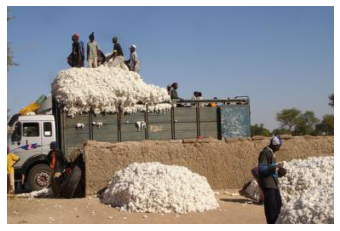

Predicted: ein <unk> auf einem dach . <end>
True: <start> <unk> mit lkw <end>
1


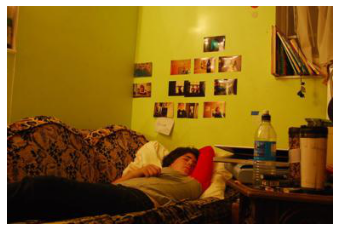

Predicted: ein mann und frau sitzen in einem raum und unterhalten sich . <end>
True: <start> ein mädchen schläft auf dem sofa . <end>
2


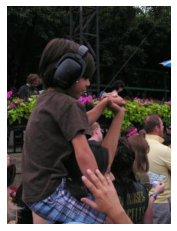

Predicted: ein mädchen in einem park . <end>
True: <start> ein kind hört musik auf den kopfhörern . <end>
3


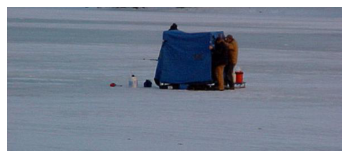

Predicted: ein <unk> und ein hund am strand . <end>
True: <start> zelten auf dem eis <end>
4


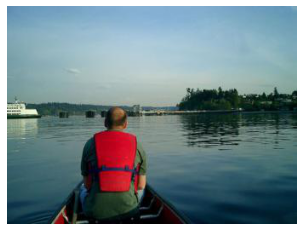

Predicted: ein auf einem see fährt ein mann mit einem kleinen kanu über einen see . <end>
True: <start> ein mann fährt einsam auf einem see . <end>
5


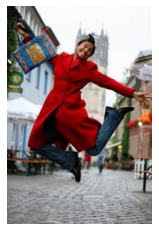

Predicted: ein mann mit roter jacke und roter jacke . <end>
True: <start> eine frau freut sich und springt <end>
6


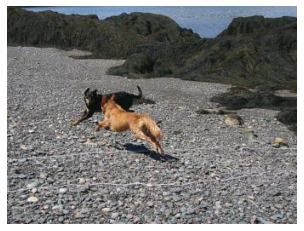

Predicted: ein hund läuft über einen strand . <end>
True: <start> ein schwarzer und ein brauner hund rennen auf steinigem boden aufeinander zu . <end>
7


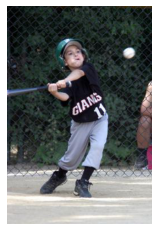

Predicted: ein junge beim baseball spielen . <end>
True: <start> ein kind beim baseball beim schlag <end>
8


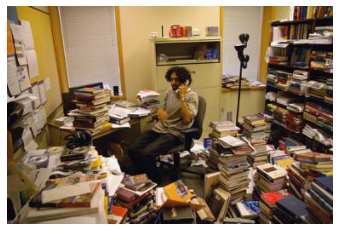

Predicted: eine frau in einem <unk> . <end>
True: <start> ein mann der zwischen bergen aus büchern sitzt und dabei telefoniert . <end>
9


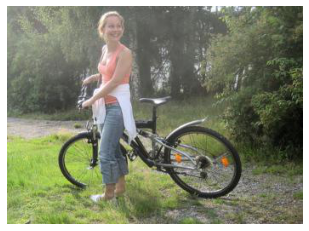

Predicted: ein junge fährt mit seinem fahrrad auf einer landstrasse <end>
True: <start> frau mit fahrrad auf einer wiese <end>
10


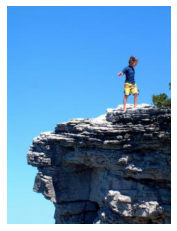

Predicted: ein kleines mädchen klettert auf einem <unk> <end>
True: <start> eine junge steht auf einem felsen . <end>
11


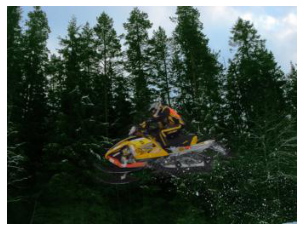

Predicted: zwei <unk> auf einem <unk> . <end>
True: <start> ein snowboarder bei einem sprung vor tannenbäumen <end>
12


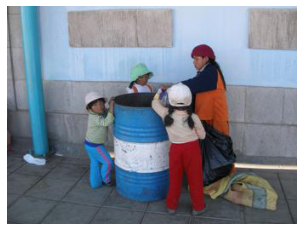

Predicted: zwei <unk> in einem raum . <end>
True: <start> eine frau und drei kinder <unk> müll . <end>
13


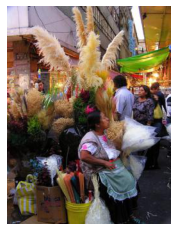

Predicted: eine gruppe von menschen , die auf einem markt sitzen . <end>
True: <start> menschen in der bunten ladenpassage <end>
14


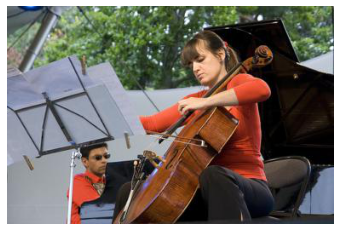

Predicted: ein mädchen in einem weißen kleid sitzt auf einem stuhl und spielt auf einer gitarre . <end>
True: <start> eine weibliche person spielt auf einem instrument . <end>
15


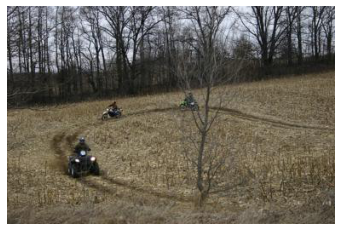

Predicted: ein hund rennt über eine wiese . <end>
True: <start> ein quad und zwei motorräder fahren auf einer <unk> <end>
16


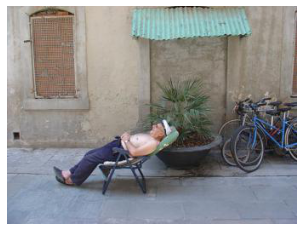

Predicted: ein mann sitzt auf einer bank und malt ein bild . <end>
True: <start> sich <unk> mann auf der liege <end>
17


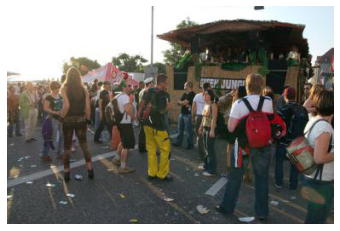

Predicted: ein viele menschen auf einem platz . <end>
True: <start> eine gruppe menschen machen party auf der straße . <end>
18


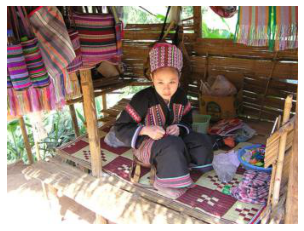

Predicted: zwei kinder sitzen in einem restaurant . <end>
True: <start> traditionell bekleidete frau sitzt in einer hütte vor <unk> stoffen . <end>
19


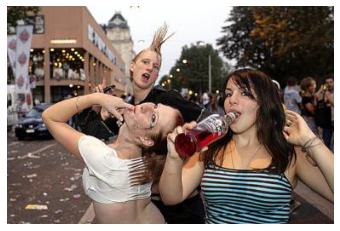

Predicted: eine frau mit einem glas bier in der hand . <end>
True: <start> ein paar jugendliche trinken alkohol auf der straße . <end>
20


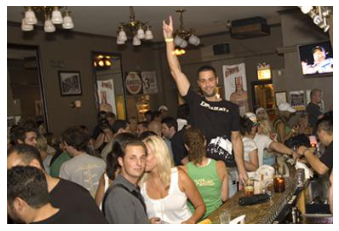

Predicted: eine gruppe von menschen in einem raum . <end>
True: <start> die leute trinken im kneipe . <end>
21


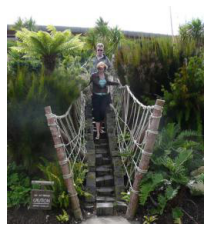

Predicted: ein <unk> <unk> über eine hängebrücke <end>
True: <start> ein pärchen auf einer hängebrücke <end>
22


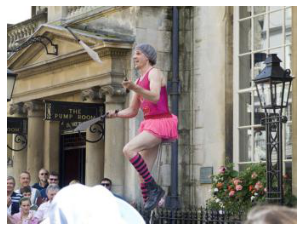

Predicted: eine frau mit langen haaren und rotem shirt , die auf einem geländer sitzt . <end>
True: <start> mann jongliert <unk> <end>
23


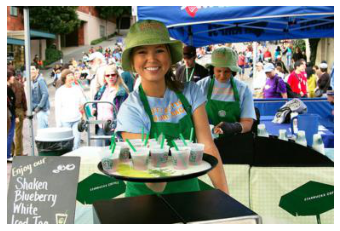

Predicted: eine frau mit einer großen weißen schürze steht an einem tisch und isst oliven . <end>
True: <start> junge frau <unk> auf tablett tee an <end>
24


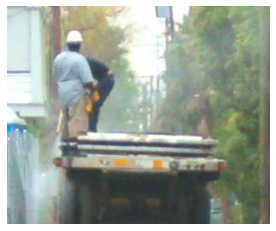

Predicted: ein mann mit helm auf einem <unk> . <end>
True: <start> zwei männer stehen auf einem transporter . <end>
25


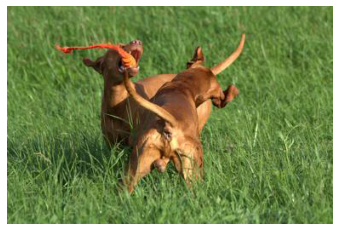

Predicted: zwei zwei hunde rennen über eine wiese . <end>
True: <start> 2 hunde beim spielen auf einer wiese <end>
26


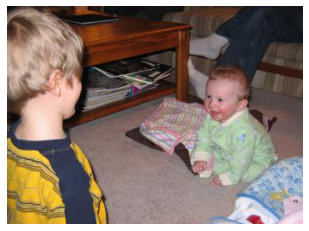

Predicted: ein kleiner junge mit einem spielzeug in der hand . <end>
True: <start> <unk> mit baby im zimmer <end>
27


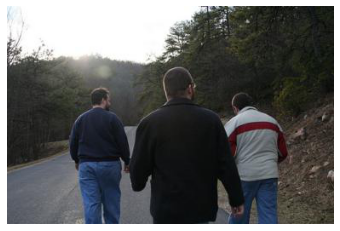

Predicted: zwei männer stehen auf einer <unk> . <end>
True: <start> drei männer gehen auf einer straße wobei man nur den <unk> sieht . <end>
28


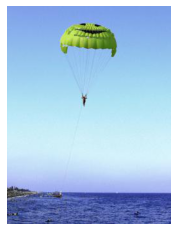

Predicted: ein <unk> <unk> mit einem großen ball . <end>
True: <start> ein grüner fallschirm wird hinter einem boot <unk> . <end>
29


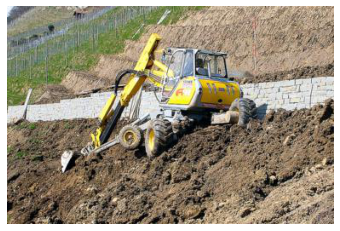

Predicted: ein <unk> fährt auf einer <unk> . <end>
True: <start> ein bagger arbeitet auf einer schräge <end>


In [157]:
import matplotlib.pyplot as plt


# Create dataset classes for training and validation.
testset = Multi30kDataset(textTokenizer, config.dataset_path, config.images_path, 
                           'val', config.language, config.max_vocabulary_size,
                           cache_path = config.cache_path, overwrite_cache = True)

# No need to use GPU for this part, make sure it is turned off.
image_captioner =  image_captioner.cpu()

for i in range(0,30):
    print(i)
    image, text = testset[i*5]
    caption = generate_caption(image_captioner, image)

    plt.figure(); plt.imshow(image); plt.axis('off');plt.show()
    print("Predicted: {}".format(caption))
    print("True: {}".format(" ".join([image_captioner.text_tokenizer.vocab.itos[c]
                             for c in text.tolist()])))

### **3. CLIP-based Classification [2pts]**

In January 2021, OpenAI published a research paper named CLIP (Contrastive Language-Image Pretraining) https://openai.com/blog/clip/. This model was trained to maximize the dot product between vector representations of text and images that have a direct correspondence and minimize their dot product when they do not correspond. One key property of this model is that it can be used to build zero-shot classifier. Since the model was trained on a large number of images and text from the web, this model knows about a lot of categories of things. Your goal in this section is to obtain the best results using the illustrated approach in this figure for the scene classification problem of Assignment 1 (SUN20). Please enter the best classification accuracy in the [leaderboard](https://docs.google.com/spreadsheets/d/1N6D9FXxk8aElRkhabcNmJwsYoI4ClBySYDwmNeKWYyQ/edit?usp=sharing) here using CLIP. 

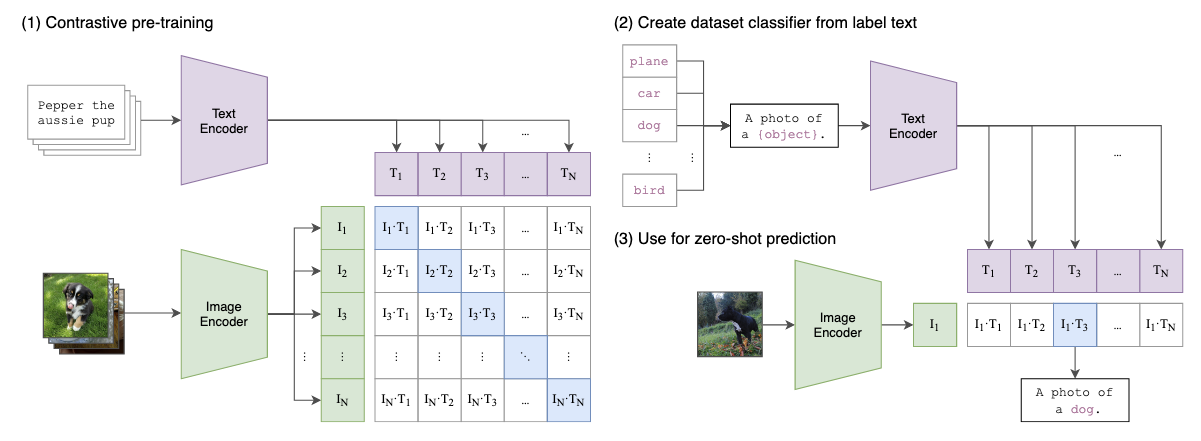

In [ ]:
# Use the ViT-B/32 available from the official repository https://github.com/openai/CLIP to implement this part.
# Keep in mind that you only have to complete step (2) from the Figure above -- this question does not need training or tuning any model.

# Your code goes here. Use as many cells as you need.


In [ ]:
!git clone --recursive https://github.com/openai/CLIP 
import CLIP

Cloning into 'CLIP'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 195 (delta 12), reused 22 (delta 9), pack-reused 168
Receiving objects: 100% (195/195), 8.91 MiB | 12.46 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [ ]:
# $ conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     |████████████████████████████████| 53 kB 1.1 MB/s 
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-fu8latz1
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-fu8latz1
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369221 sha256=bd7f0577ea9bd08f0703a2b7921c13ba2da12117db7d46f4d3aa29f601e2a93c
  Stored in directory: /tmp/pip-ephem-wheel-cache-81jkw4d5/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [ ]:
# This command downloads the files with the prepackaged contents.
!wget -nc http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-train-sm.tar.gz
!wget -nc http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-val.tar.gz
!tar xf SUN20-train-sm.tar.gz
!tar xf SUN20-val.tar.gz

--2022-03-12 00:11:51--  http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-train-sm.tar.gz
Resolving www.cs.rice.edu (www.cs.rice.edu)... 128.42.207.26
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:80... connected.
HTTP request sent, awaiting response... 302 Found : Moved Temporarily
Location: https://www.cs.rice.edu/~vo9/deep-vislang/SUN20-train-sm.tar.gz [following]
--2022-03-12 00:11:51--  https://www.cs.rice.edu/~vo9/deep-vislang/SUN20-train-sm.tar.gz
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39744791 (38M) [application/x-gzip]
Saving to: ‘SUN20-train-sm.tar.gz’

SUN20-train-sm.tar. 100%[===================>]  37.90M  2.87MB/s    in 13s     

2022-03-12 00:12:04 (2.84 MB/s) - ‘SUN20-train-sm.tar.gz’ saved [39744791/39744791]

--2022-03-12 00:12:05--  http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-val.tar.gz
Resolving www.cs.rice.edu (www.cs.rice.edu)... 128.42.207.26
Connecti

In [ ]:
import os, json, pickle, random
import torch.utils.data
from PIL import Image

# Simple implementation of a custom data loading class for our SUN20 dataset.
class SUN20(torch.utils.data.Dataset):

  # Initialize the class e.g. load files, preprocess, etc.
  def __init__(self, split = 'train', transform = None):
    
    # These are the 20 categories selected.
    self.categories = open('SUN20/' + split + '/ClassName.txt').read().split('\n')[:-1]
    self.categories = sorted(self.categories)
    self.category2index = {category: idx for (idx, category) in enumerate(self.categories)}
    self.transform = transform

    # Compile a list of images and corresponding labels.
    self.imagepaths = []
    self.labels = []
    for category in self.categories:
      category_directory = 'SUN20/' + split + category
      category_imagenames = os.listdir(category_directory)
      self.imagepaths += [os.path.join(category_directory, imagename) 
                          for imagename in category_imagenames]
      self.labels += [self.category2index[category]] * len(category_imagenames)

    # Sort imagepaths alphabetically and labels accordingly.
    sorted_pairs = sorted(zip(self.imagepaths, self.labels), key = lambda x: x[0])
    self.imagepaths, self.labels = zip(*sorted_pairs)

        
  # Return a sample (x, y) as a tuple e.g. (image, label)
  def __getitem__(self, index):
    image = Image.open(self.imagepaths[index]).convert('RGB')
    if self.transform:
      image = self.transform(image)
    return image, self.labels[index]
  
  # Return the total number of samples.
  def __len__(self):
    return len(self.imagepaths)


In [ ]:
trainset = SUN20(split = 'train')
valset = SUN20(split = 'val')

In [ ]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)


In [ ]:
n = len(valset)
true_prediction = 0
for i in range(n):
  image, class_id = valset[i]
  image_input = preprocess(image).unsqueeze(0).to(device)
  text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in valset.categories]).to(device)

  # Calculate features
  with torch.no_grad():
      image_features = model.encode_image(image_input)
      text_features = model.encode_text(text_inputs)

  # Pick the top 5 most similar labels for the image
  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
  values, indices = similarity[0].topk(1)
  if indices == class_id:
    true_prediction += 1

In [ ]:
print("The prediction accuracy is : ", true_prediction/n)

The prediction accuracy is :  0.856


**Required Answers**: Is this model better than the classifier you trained from scratch in Assignment 1? Is this model better than the classifier you finetuned from a pretrained CNN in Assignment 1?

The model is better than the classifier I trained from scratch in Assigment 1, but worse than the classifier I finetuned from a pretrained CNN